In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

# Soil Organic Matter canister spectra

Spectra obtained 4/2/21

# Get spectra from automatic insertion

In [2]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

tests_210402_file = "210402_SOC_canister/tests_210402.h5"

file = path_name + tests_210402_file

with h5py.File(file, 'r') as h5_file:
    print(h5_file['session002/cal001/ins001/derived'].keys())

<KeysViewHDF5 ['absorbance_depth', 'absorbance_depth_timestamps', 'depth_increment_data', 'force_depth', 'force_depth_timestamps']>


In [3]:
def get_absorbance_depth(file_string, insertion_string):
    with h5py.File(file_string, 'r') as h5_file:
        abs_depth = h5_file[f'{insertion_string}/derived/absorbance_depth'][:]
        return abs_depth
                            

In [4]:
ins001 = get_absorbance_depth(file, 'session002/cal001/ins001')

In [5]:
ins001df = pd.DataFrame(ins001)

In [6]:
ins001df = ins001df.rename(columns={1212:'force', 1213:'depth'})

# Get and concatentate stationary spectra

In [7]:
insertions = ['ins002', 'ins003', 'ins004', 'ins005', 'ins006',
             'ins007', 'ins008']

In [8]:
vis_frames = []
ftir_frames = []
for insertion in insertions:
    with h5py.File(file, 'r') as h5_file:
        vis_ins_abs = h5_file[f'session002/cal001/{insertion}/spectrometer1/derived/absorbances'][:]
        ftir_ins_abs = h5_file[f'session002/cal001/{insertion}/spectrometer2/derived/absorbances'][:]
    vis_abs_df = pd.DataFrame(vis_ins_abs)
    vis_frames.append(vis_abs_df)
    ftir_abs_df = pd.DataFrame(ftir_ins_abs)
    ftir_frames.append(ftir_abs_df)
stationary_vis_df = pd.concat(vis_frames, ignore_index=True)
stationary_ftir_df = pd.concat(ftir_frames, ignore_index=True)
    
    

In [9]:
stationary_df = pd.concat([stationary_vis_df, stationary_ftir_df], axis=1, ignore_index=True)

In [10]:
depths = [20.2, 27.2, 34.4, 41.5, 48.4, 55.3, 62.4]

In [11]:
for i in range(len(depths)):
    stationary_df.loc[i*3, 'depth'] = depths[i]
    stationary_df.loc[i*3+1, 'depth'] = depths[i]
    stationary_df.loc[i*3+2, 'depth'] = depths[i]

In [12]:
ins001df['depth'] = ins001df['depth'] + 2

In [13]:
with h5py.File(file, 'r') as h5_file:
    vis_waves = h5_file['session002/cal001'].attrs['spec1_wavelengths_vector'][:]
    ftir_waves = h5_file['session002/cal001'].attrs['spec2_wavelengths_vector'][:]

# Plot stepped spectra with automatic spectra from the same depths

Both visible and ftir engine spectra.

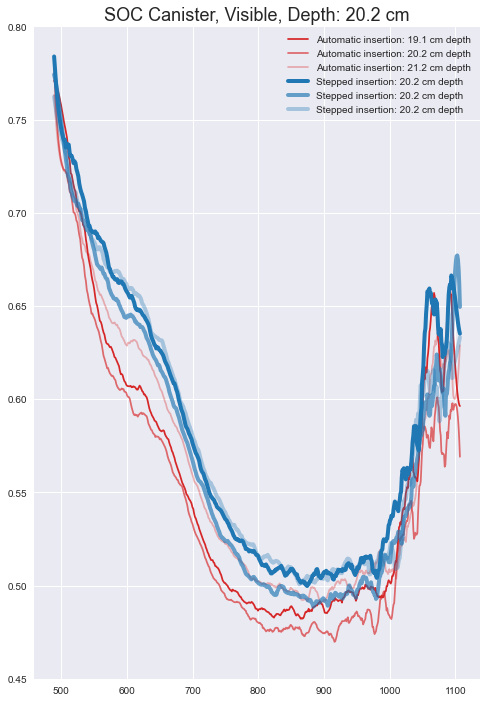

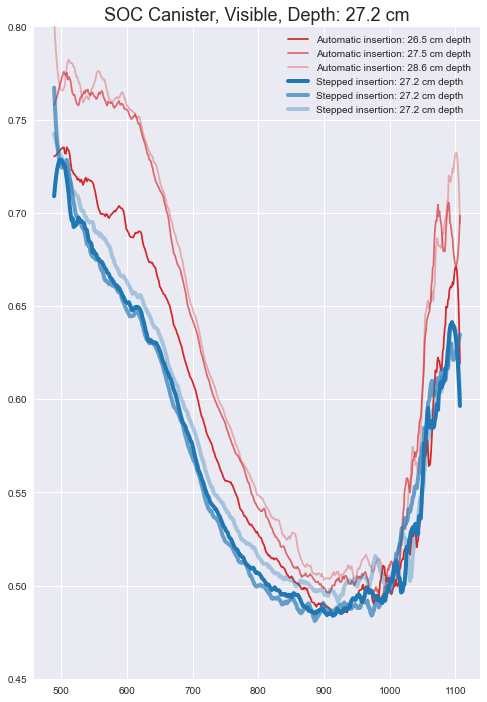

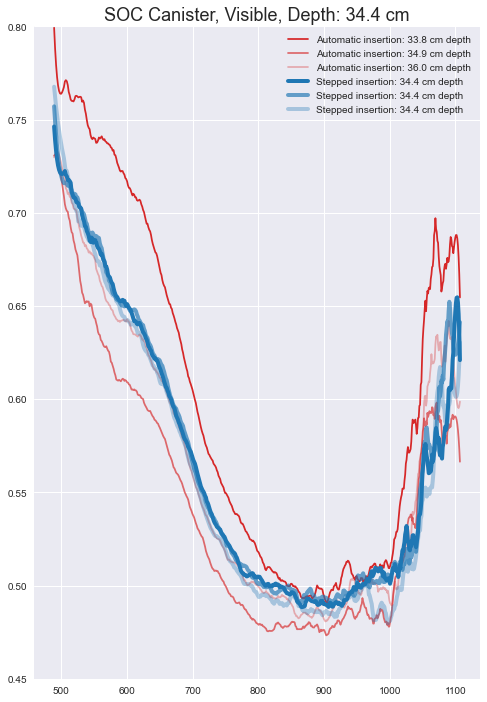

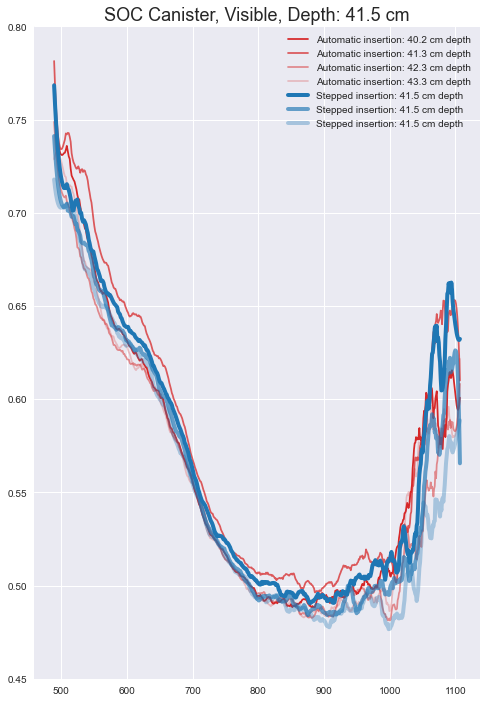

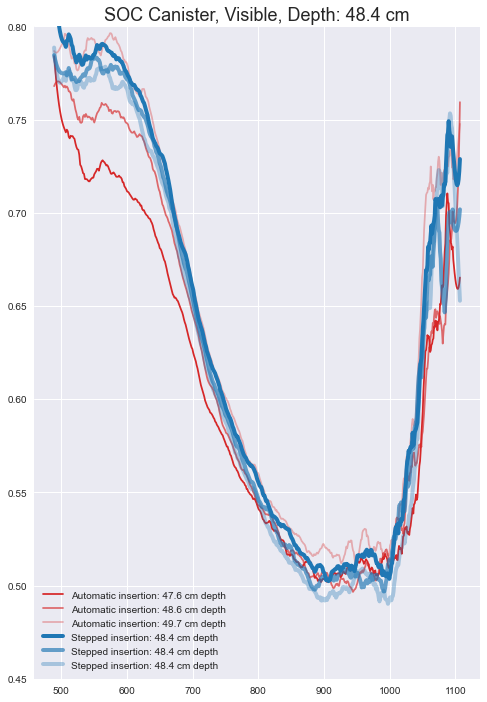

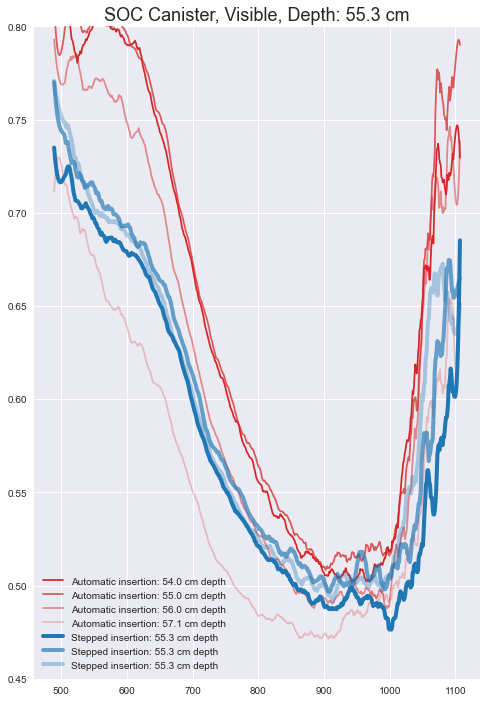

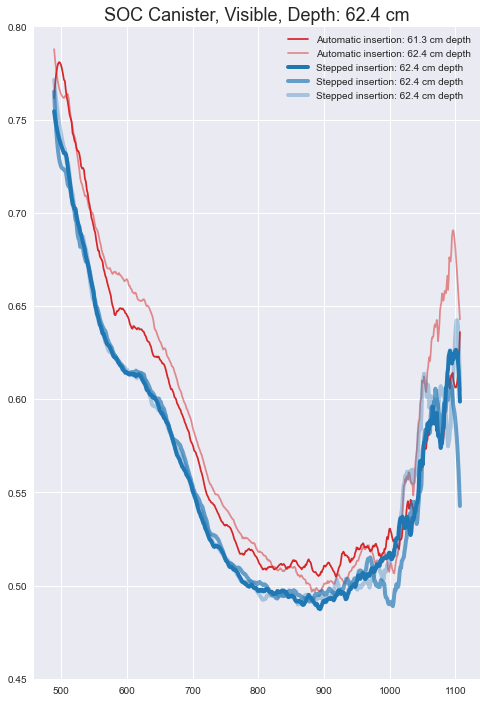

In [14]:
for depth in depths:
    moving = ins001df.loc[(ins001df['depth'] > (depth - 1.5)) & (ins001df['depth'] <= (depth + 2.0))].copy()
    stationary = stationary_df.loc[stationary_df['depth'] == depth].copy()
    vis_moving = moving.iloc[:, :512]
    
    vis_stationary = stationary.iloc[:, :512]
    
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.set_title(f"SOC Canister, Visible, Depth: {depth} cm", fontsize=18)
    ax.set_ylim(0.45, 0.80)
    count = vis_moving.shape[0]
    for i in range(count):
        moving_depth = moving.iat[i, -1]
        label = f'Automatic insertion: {moving_depth:0.1f} cm depth'
        alpha = 1 - (i/count)
        ax.plot(vis_waves, savgol_filter(vis_moving.iloc[i, :], 21, 3), 'tab:red', alpha=alpha, label=label)
    count = vis_stationary.shape[0]    
    for i in range(count):
        label = f'Stepped insertion: {depth:0.1f} cm depth'
        alpha = 1 - (i/count)
        ax.plot(vis_waves, savgol_filter(vis_stationary.iloc[i, :], 21, 3), 'tab:blue', lw=4.0, alpha=alpha, label=label)
    leg = ax.legend()
    plt.show()
    plt.close()


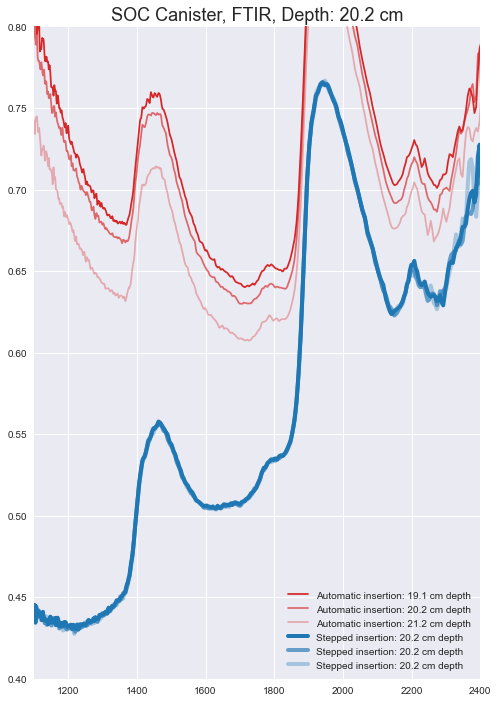

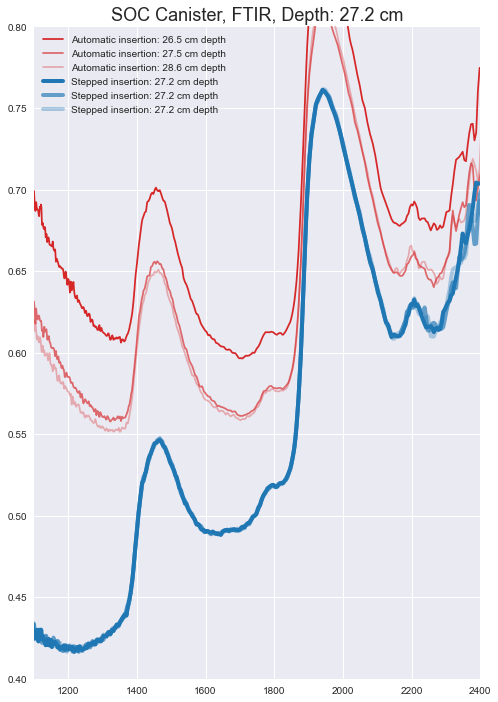

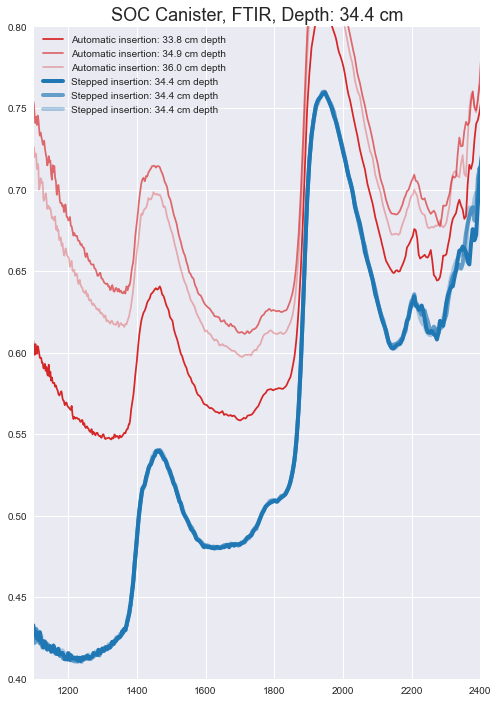

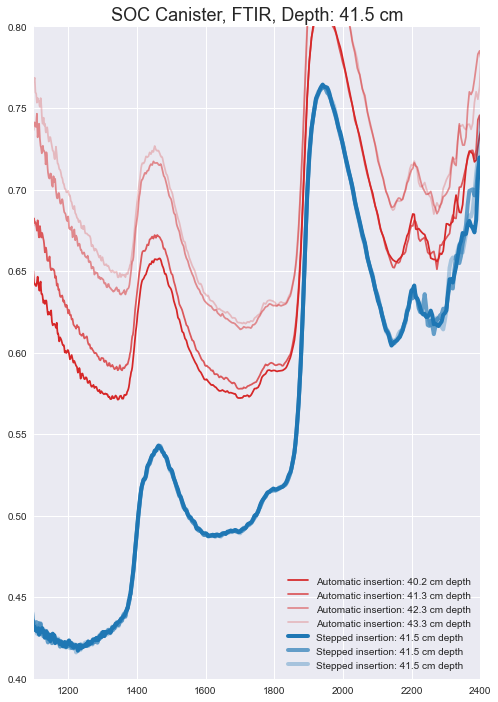

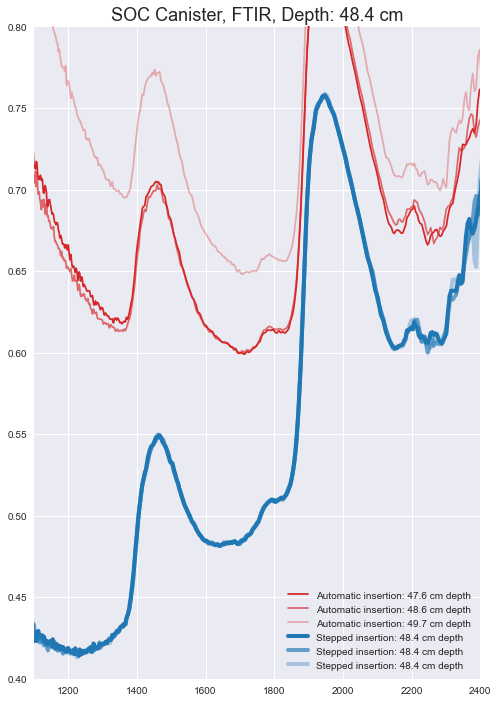

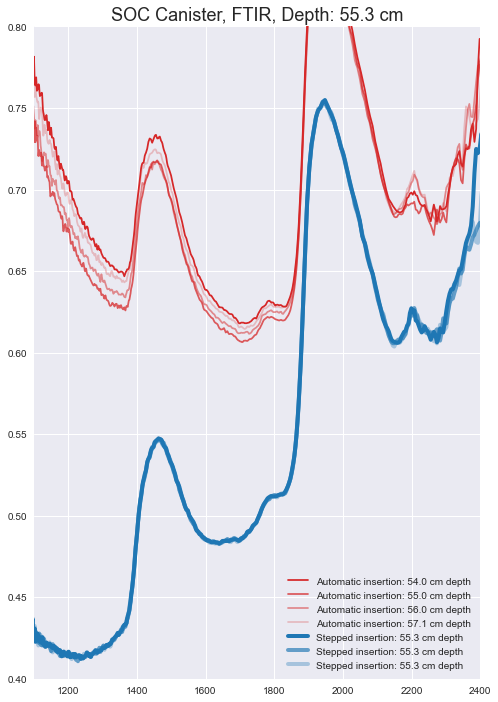

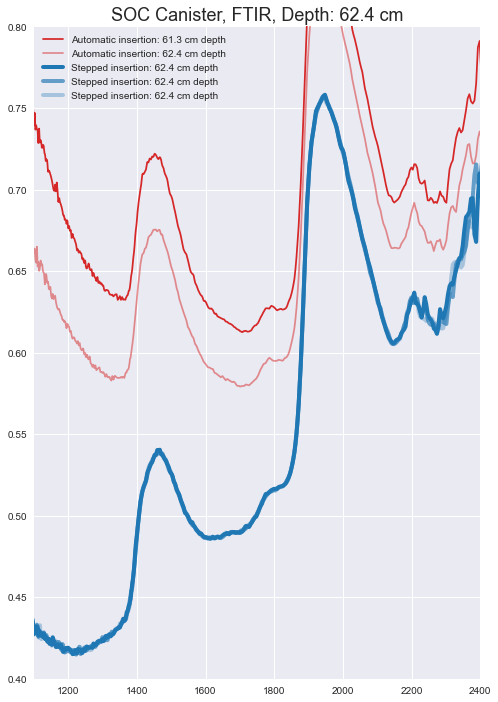

In [15]:
for depth in depths:
    moving = ins001df.loc[(ins001df['depth'] > (depth - 1.5)) & (ins001df['depth'] <= (depth + 2.0))].copy()
    stationary = stationary_df.loc[stationary_df['depth'] == depth].copy()
    
    ftir_moving = moving.iloc[:, 512:-2]
    ftir_stationary = stationary.iloc[:, 512:-1]
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.set_title(f"SOC Canister, FTIR, Depth: {depth} cm", fontsize=18)
    ax.set_xlim(1100, 2400)
    ax.set_ylim(0.4, 0.8)
    count = ftir_moving.shape[0]
    for i in range(count):
        moving_depth = moving.iat[i, -1]
        label = f'Automatic insertion: {moving_depth:0.1f} cm depth'
        alpha = 1 - (i/count)
        ax.plot(ftir_waves, ftir_moving.iloc[i, :], 'tab:red', alpha=alpha, label=label)
    count = ftir_stationary.shape[0]    
    for i in range(count):
        label = f'Stepped insertion: {depth:0.1f} cm depth'
        alpha = 1 - (i/count)
        ax.plot(ftir_waves,ftir_stationary.iloc[i, :], 'tab:blue', lw=4.0, alpha=alpha, label=label)
    leg = ax.legend()
    plt.show()
    plt.close()

# Plot all the stepped insertion spectra for FTIR engine

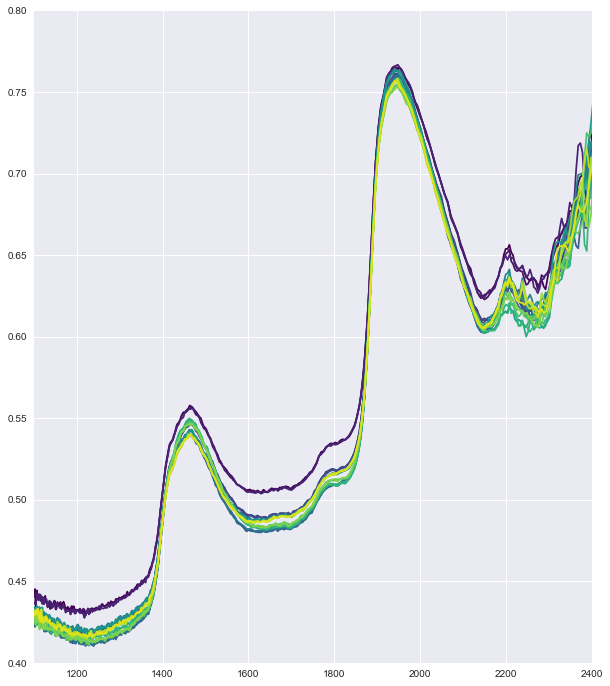

In [16]:
fix, ax = plt.subplots(figsize=(10, 12))
ax.set_ylim(0.4, 0.8)
ax.set_xlim(1100, 2400)
for i in range(stationary_df.shape[0]):
    color = plt.cm.viridis(i/stationary_df.shape[0])
    ax.plot(ftir_waves, stationary_df.iloc[i, 512:-1], color=color)

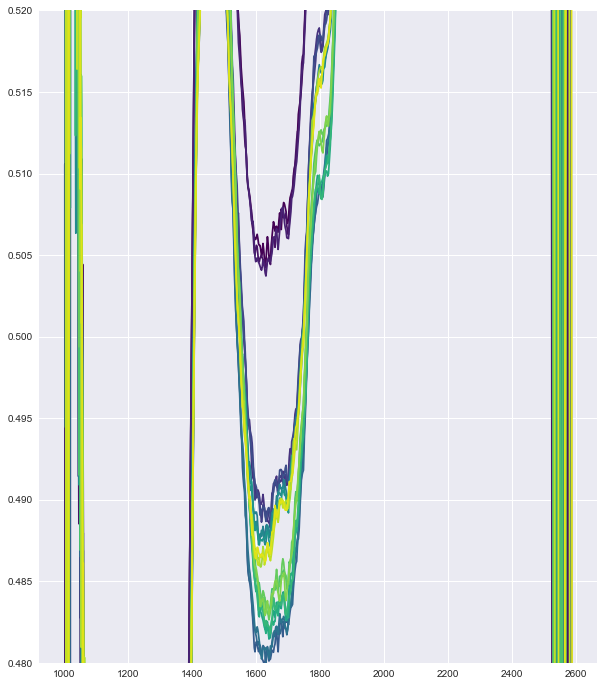

In [17]:
fig, ax = plt.subplots(figsize=(10, 12))
ax.set_ylim(0.48, 0.52)
for i in range(stationary_df.shape[0]):
    color = plt.cm.viridis(i/stationary_df.shape[0])
    ax.plot(ftir_waves, stationary_df.iloc[i, 512:-1], color=color)

# Plot all the stepped insertion spectra for the visible light spectrometer

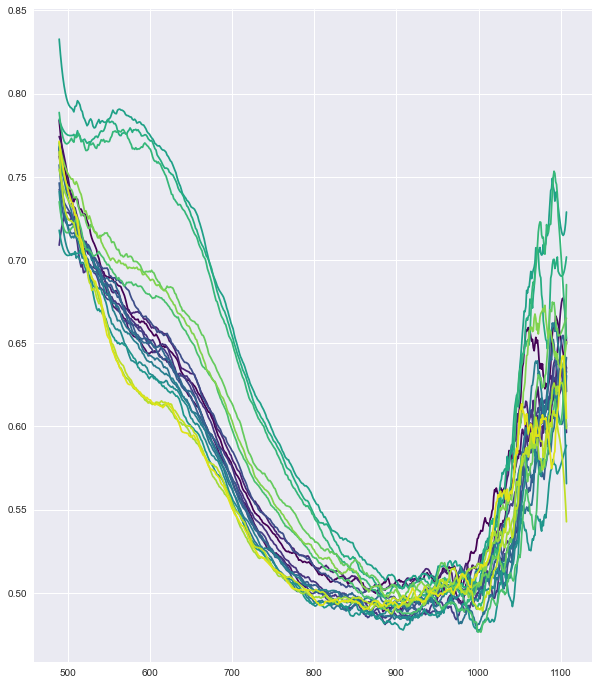

In [18]:
fix, ax = plt.subplots(figsize=(10, 12))
# ax.set_ylim(0.4, 0.56)
for i in range(stationary_df.shape[0]):
    color = plt.cm.viridis(i/stationary_df.shape[0])
    ax.plot(vis_waves, savgol_filter(stationary_df.iloc[i, :512], 21, 3), color=color)

# Plot all the spectra from the automatic insertion for the FTIR engine

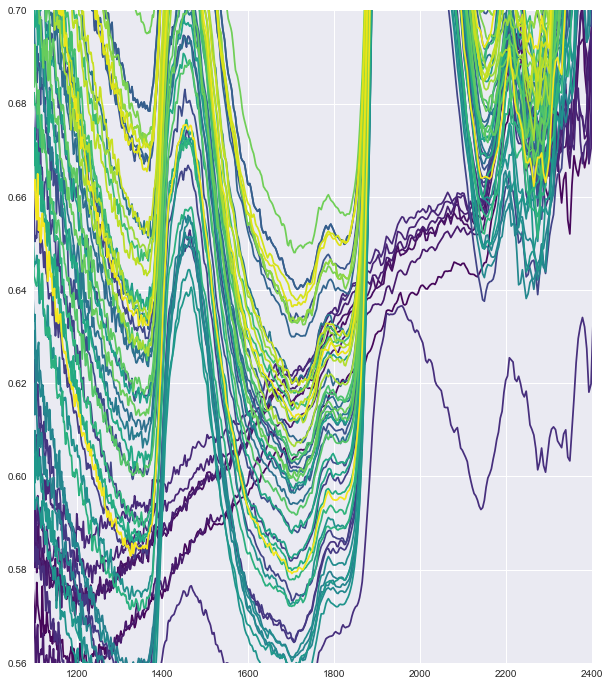

In [19]:
fig, ax = plt.subplots(figsize=(10, 12))
ax.set_ylim(0.56, 0.70)
ax.set_xlim(1100, 2400)
for i in range(ins001df.shape[0]):
    color = plt.cm.viridis(i/ins001df.shape[0])
    ax.plot(ftir_waves, ins001df.iloc[i, 512:-2], color=color)

# Plot all the spectra from the automatic insertion for the visible light spectrometer

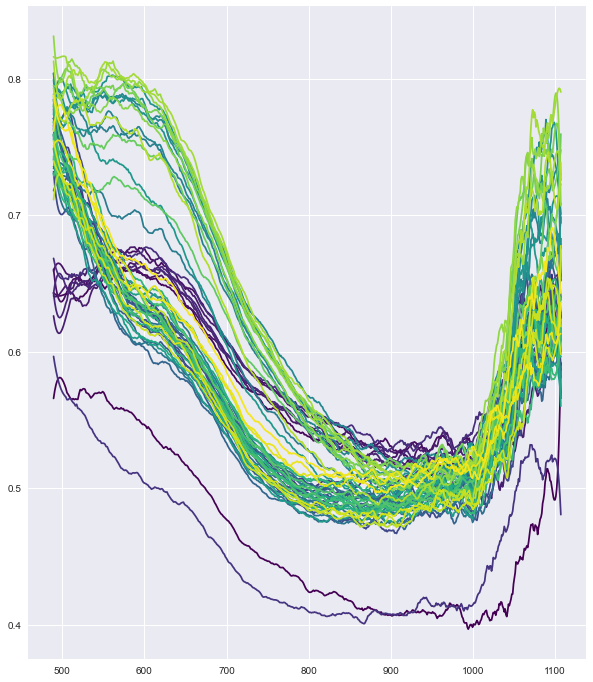

In [20]:
fig, ax = plt.subplots(figsize=(10, 12))
# ax.set_ylim(0.56, 0.70)
for i in range(ins001df.shape[0]):
    color = plt.cm.viridis(i/ins001df.shape[0])
    ax.plot(vis_waves, savgol_filter(ins001df.iloc[i, :512], 21, 3), color=color)